In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from metrics import *

In [277]:
data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterA_high.csv',header=None)
data = ((data) * 2.0)-1

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


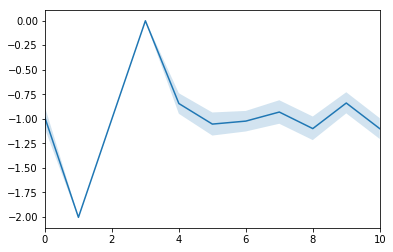

In [278]:
sns.tsplot(np.array(data))

In [311]:
class Rapooc_test(object):
    def __init__(self, D, k, l, K):
        self._D = np.array(D)
        assert k>0 and l >0, "invalid values, k>0 and l>0"
        self._k = k
        self._l = l
        assert K <= k*l and k>=1, "invalid values, 1<= K <= k*l"
        self._K = K
        self._rho = np.ones(D.shape[0])
        self._gamma = np.ones(D.shape[1])
        self._M, self._N = self._D.shape
        self._rows_h_score = None
        self._cols_h_score = None
        self._cluster_H_values = np.array([ [0.0] * (int(self._l) + 1)  
                                    for _ in range(int(self._k + 1))])
    
    @property
    def rho(self):
        return self._rho
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def bicluster_h_values(self):
        assert not self._cluster_H_values is None, "H values have not yet been calculated"
        return self._cluster_H_values

    def initialize(self):
        i = 1
        j = 1
        while (i < self._k or j < self._l):
            if i < self._k:
                i += 1
                alpha = self._argmin_H_(self._rho, self._gamma,'row')
                self._bisect_partitions_(self._D[np.where(self._rho ==alpha)], self._rho, alpha, i,'row')
            if j < self._l:
                j += 1
                least_coherent_column, lowest_cluster  = self._argmin_H_(self._rho,self._gamma, 'column',j)
                print(self._gamma)
                # self._bisect_partitions_(self._D.T, self._gamma, beta, j,'column')   
                self._bisect_columns_(lowest_cluster, least_coherent_column, j)

    def _argmin_H_(self, row_co_cluster, col_co_cluster,option='row',n_col_iterations = 1):
        if (option=='row'):
            data = self._D
            h_min = math.inf
            min_cocluster = 1
            map_array = np.int64(row_co_cluster if option == 'row' else col_co_cluster)
            max_index_in_map = np.max(map_array)
            for i in range(1,max_index_in_map + 1):
                if (list(map_array).count(i) < 2):
                    pass
                else:
                    coherence = PairBasedCoherence(
                        data[np.where((row_co_cluster if option == 'row' else col_co_cluster) == i)]).HP 
                    if (coherence <= h_min):
                        h_min = coherence
                        min_cocluster = i
            return min_cocluster
        else:
            data = self._D.T
            least_coherent_item = -1
            lowest_coherence = 1 # max coherence
            lowest_cluster= 0
            i = 1
            for i in range(1,n_col_iterations):
                #Iter for each cluster
                clusterer = BisectingClusterer(data[np.where(self._gamma == i)])
                aux_least_coherent_item, aux_lowest_coherence = clusterer.least_coherent_item()
                if(aux_lowest_coherence <= lowest_coherence):
                    lowest_coherence, least_coherent_item = aux_lowest_coherence, aux_least_coherent_item
                    lowest_cluster = i
            return least_coherent_item, lowest_cluster
    
    def _bisect_partitions_ (self, data, mapping_array, cluster_to_replace, new_cluster_index,option='row'):
        clusterer = BisectingClusterer(data)
        bisected_map = clusterer.fit()
        bisected_map_index = 0
        for i in range(0,len(mapping_array)):
            if ((self._rho if option == 'row' else self._gamma)[i] == cluster_to_replace):
                if (bisected_map[bisected_map_index] == 1.0):
                    (self._rho if option == 'row' else self._gamma)[i] = new_cluster_index
                bisected_map_index += 1
                
    def _bisect_columns_(self, cluster_to_replace, least_coherent_column, next_cluster):
        last_occurrence = (np.where(self._gamma == cluster_to_replace)[0][-1] + 1)
        offset_occurrence = (np.where(self._gamma == cluster_to_replace)[0][0])
        least_coherent_column += offset_occurrence
        print("% debug % to replace " + str(cluster_to_replace) + " least coherent " + str(least_coherent_column))
        self._gamma[least_coherent_column:last_occurrence] = next_cluster
       
    def _compute_objective_function_(self):
        
        self._cluster_H_values = np.array([ [0.0] * (int(self._l) + 1)  
                                    for _ in range(int(self._k + 1))])

        for i in range(1,int(max(self._rho) + 1)):
            for j in range (1, int(max(self._gamma) + 1)):
                # print("% debug % cluster i " + str(i) + " cluster j " + str(j))
                coherence = PairBasedCoherence(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              np.where(self._gamma == j)[0])]).HP
                
                # print(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              # np.where(self._gamma == j)[0])])
                try:
                    self._cluster_H_values[i][j] = coherence
                except IndexError:
                    print(" i " + str(i) + " j " +str(j) +" shape 0 "+ str(self._cluster_H_values.shape[0]) \
                          + " shape 1 "\
                          + str(self._cluster_H_values.shape[1]))
            
        print(self._cluster_H_values)
        
        h_values_1d = self._cluster_H_values.flatten()
        
        idx_1d = h_values_1d.argsort()[-self._K:]
        
        x_idx, y_idx = np.unravel_index(idx_1d, self._cluster_H_values.shape)
        
        acc=0
        for x, y, in zip(x_idx, y_idx):
            print("% debug % x_idx " + str(x) +" y_idx " +str(y) + " H value "+ str(self._cluster_H_values[x][y]))
            acc += self._cluster_H_values[x][y]
        
        print("%debug % FO value " + str(acc/self._K) + " accumulator "+str(acc))
        return (acc/(self._K))
    
    def core_co_clustering(self):
        
        n_iterations = 0
        n_repetitions = 0
        of_last_value = 0
        best_iter = 0
        best_OF = 0
        best_rows = self._rho
        best_columns = self._gamma
        while(n_iterations < (self._k * self._l) and n_repetitions < int((self._k * self._l) * 0.3)):
            
            if(n_iterations == 0): 
                objective_function = 0 
            else: 
                objective_function=self._compute_objective_function_() 
            temp_rows = self._update_maps_(option = 'rows')
            temp_columns = self._update_maps_(option = 'columns')
            
            if (objective_function > best_OF):
                best_iter = n_iterations
                best_OF = objective_function
                best_rows = temp_rows
                best_columns = temp_columns
            # break conditions
            if (math.fabs(1 - objective_function) < 0.3):
                break
            """ 
            if(math.fabs(objective_function - of_last_value) > 0.001):
                of_last_value = objective_function
                n_repetitions = 0
            else:
                n_repetitions += 1
            """     
            n_iterations += 1
        
        self._rho = best_rows
        self._gamma = best_columns
        print("Finishing core-coclustering")
        print("Number of iterations " + str(n_iterations))
        print("Objective function " + str(math.fabs(best_OF)) + " at iter " +str(best_iter))
        print("Number of repetitions " + str(n_repetitions))
        '''
        for i in range(1,int(max(self._rho) + 1)):
            for j in range (1, int(max(self._gamma) + 1)):
                print("% debug % cluster i " + str(i) + " cluster j " + str(j))
                print(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              np.where(self._gamma == j)[0])])
        '''
    
        # ax = sns.tsplot(data= self._D[np.ix_(np.where(self._rho == 1)[0],np.where(self._gamma == 2)[0])] 
                                # , err_style="unit_traces")
    def _update_maps_(self,option = 'rows'):
        
        if(option == 'rows'):
            mapping_array = self._rho
            data = self._D
        elif (option == 'columns'):
            mapping_array = self._gamma
            data = self._D.T
            
        for i in range(0,len(data)):
            self._compute_arg_max_(data,mapping_array,i)
            
        return np.copy(mapping_array)
    
    def _compute_arg_max_(self,data,mapping_array,index):
        
        actual_coherence = 0
        previous_cluster = mapping_array[index]
        if (list(mapping_array).count(previous_cluster) <= 2):
            return
        prev_coherence = PairBasedCoherence(data[np.where(mapping_array == previous_cluster)]).HP
        
        mapping_array[index] = 0
        
        local_coherence = PairBasedCoherence(data[np.where(mapping_array == previous_cluster)]).HP
        
        if (prev_coherence >= local_coherence):
            mapping_array[index] = previous_cluster
            actual_coherence = prev_coherence
        else:
            actual_coherence = local_coherence
            
        best_cluster,best_coherence = self._iter_maps_(data, mapping_array, index, previous_cluster)
        
        if (best_coherence > local_coherence):
            mapping_array[index] = best_cluster
    
    def _iter_maps_(self, data, mapping_array, index, previous_cluster):
        
        best_coherence = 0
        best_cluster = 0
        
        for actual_cluster in range(1,int(max(mapping_array))+1):
            if actual_cluster == previous_cluster:
                pass
            else:
                mapping_array[index] = actual_cluster
                coherence = PairBasedCoherence(data[np.where(mapping_array == actual_cluster)]).HP
                if(coherence >= best_coherence):
                    best_coherence = coherence
                    best_cluster = actual_cluster
                    # print("% debug %" + str(coherence))
                    
        return best_cluster, best_coherence

In [312]:
rapooc = Rapooc_test(data,2,5,3)

In [313]:
rapooc.initialize()

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
% debug % to replace 1 least coherent 7
[ 1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.]
% debug % to replace 2 least coherent 7
[ 1.  1.  1.  1.  1.  1.  1.  3.  3.  3.  3.]
% debug % to replace 3 least coherent 7
[ 1.  1.  1.  1.  1.  1.  1.  4.  4.  4.  4.]
% debug % to replace 4 least coherent 7


In [314]:
rapooc.core_co_clustering()

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.64295733  0.          0.          0.51924951  0.80636121]
 [ 0.          0.70345732  0.          0.          0.54508503  0.81282267]]
% debug % x_idx 2 y_idx 1 H value 0.703457318338
% debug % x_idx 1 y_idx 5 H value 0.806361214936
% debug % x_idx 2 y_idx 5 H value 0.812822668493
%debug % FO value 0.774213733922 accumulator 2.32264120177
Finishing core-coclustering
Number of iterations 1
Objective function 0.7742137339223861 at iter 1
Number of repetitions 0


/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


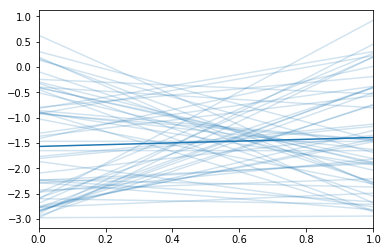

In [317]:
sns.tsplot(data= rapooc._D[np.ix_(np.where(rapooc._rho == 2)[0],np.where(rapooc._gamma == 1)[0])],err_style="unit_traces")

In [236]:
class BisectingClusterer(object):
    def __init__(self, data):
        
        if data is not None:
            self._data = np.array(data)
            self._I, self._J = self._data.shape
        else:
            print("Empty data")
    
    @property
    def centroids(self):
        if self._centroids is not None:
            return self._centroids
        else:
            print ("centroids not computed yet")
            return [0,0]
    
    def least_coherent_item(self):        
        #this correlation refers the maximum least correlated pair of columns
        max_correlation = 1
        least_coherent = 0
        i = 0
        for i in range(self._I - 1):
            correlation = PositiveNegativeCorrelation(self._data[i],
                                                      self._data[i+1],
                                                      self._J).H_pos
            if(correlation < max_correlation):
                max_correlation = correlation
                least_coherent = i
        # returns index of least coherent intem and its correlation
        return least_coherent, max_correlation

    def fit(self):
        self._centroids = self._compute_centroids_()
        bisecting_indices = self._bisect_clusters_(self._centroids)
        return bisecting_indices
    
    def _compute_centroids_(self):
        max_correlation = 0
        centroids = [0,0]
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def _bisect_clusters_(self, centroids):
        cluster_indices = np.zeros(self._I)
        for i in range(self._I):
            correlation0 = PositiveNegativeCorrelation(
                self._data[centroids[0]], self._data[i],self._J).H_pos
            correlation1 = PositiveNegativeCorrelation(
                self._data[centroids[1]], self._data[i],self._J).H_pos
            if(correlation0 <= correlation1):
                cluster_indices[i] = 1
        return cluster_indices

In [306]:
class PositiveNegativeCorrelation(object):
    def __init__(self, x, y, J):
        self._x = x
        self._y = y
        self._J = J
        self._x_mean = np.mean(x)
        self._y_mean = np.mean(y)
        self._H_pos = None
        self._H_neg = None

    @property
    def H_pos(self):
        if self._H_pos is None:
            # print("Computing H positive...")
            self._H_pos = self._compute_H_pos()
            # print("H positive value: " + str(self._H_pos))
        return self._H_pos

    @property
    def H_neg(self):
        if self._H_neg is None:
            # print("Computing H negative...")
            self._H_neg = self._compute_H_neg()
            # print("H negative value: " + str(self._H_neg))
        return self._H_neg

    def _compute_H_pos(self):
        H_pos = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) -
                    (self._y[j] - self._y_mean))/2.0)**2
            H_pos += aux
        if (self._J>0):
            H_pos *= 1.0/(math.fabs(self._J))
            H_pos = 1 - H_pos
        else:
            H_pos = 0
        return H_pos

    def _compute_H_neg(self):
        H_neg = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) +
                    (self._y[j] - self._y_mean))/2.0)**2
            H_neg += aux
        H_neg *= 1.0/math.fabs(self._J)
        H_neg = 1 - H_neg
        return H_neg
    
class PairBasedCoherence(object):
    def __init__(self, X):
        self._X = np.array(X)
        self._I, self._J = X.shape
        self._HP = None

    @property
    def HP(self):
        if self._HP is None:
            # print("Calculating Pair based coherence..")
            self._HP = self._compute_HP_()
            # print("Paired based coherence value: " + str(self._HP))
        return self._HP

    def _compute_HP_(self):
        HP = 0
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i==j): 
                    break
                x = self._X[i]
                y = self._X[j]
                correlation = PositiveNegativeCorrelation(x, y,self._J)
                H0 = correlation.H_pos
                # H0 = max(correlation.H_pos,correlation.H_neg)
                HP += H0
        HP *= math.fabs(2.0)/(math.fabs(self._I)*(math.fabs(self._I)-1))  if self._I > 1 else 0
        
        return HP

In [114]:
y = np.array([1,2,3,3,3,3,4,5,])
np.where(y==3)

(array([2, 3, 4, 5]),)

In [109]:
x = y[np.where(y==3)]
x

array([3, 3, 3, 3])

In [110]:
for i in np.where(y==3)[0].tolist()[3:]:
    print(i)

5


In [111]:
np.nditer(np.where(y==3))

In [112]:
y[3:] = -1

In [115]:
y

array([1, 2, 3, 3, 3, 3, 4, 5])

In [119]:
 np.where(y==3)[0][-1]

5

In [220]:
y

array([1, 2, 3, 3, 3, 3, 4, 5])

In [222]:
y[2:7]

array([3, 3, 3, 3, 4])